In [1]:
cores="1"
hosts="1"
threads="8"

import sys
sys.path.append("/path/to/PyOphidia")
sys.path.append("/path/to/esdm-pav-client")

In [2]:
from esdm_pav_client import Workflow, Experiment
experiment = Experiment(
    name="Cold Spells",
    author="CMCC",
    abstract="Perform the computation of Cold Spells indexes using ESDM PAV",
    exec_mode="sync",
    host_partition="cluster",
    ncores=cores)
t0 = experiment.newTask(name="Create climate averages",
                type="cdo",
                operator='-ydaymean -runavg,5 -delete,dom=29feb -mergetime',
                arguments={'input': '/path/to/input/past/*.nc',
                           'output': '/path/to/output/climatological_mean.nc'})
t1 = experiment.newTask(name="Create container",
                type="ophidia",
                operator='oph_createcontainer',
                on_error='skip',
                arguments={'container': 'coldspells',
                           'dim': 'lat|lon|time',
                           'dim_type': 'double|double|double',
                           'hierarchy': 'oph_base|oph_base|oph_time'})
t2 = experiment.newTask(name="Import climate averages",
                type="ophidia",
                operator='oph_importnc2',
                arguments={'measure': 'tasmin',
                           'container': 'coldspells',
                           'import_metadata': 'yes',
                           'imp_dim': 'time', 
                           'imp_concept_level': 'd',
                           'hierarchy': 'oph_base|oph_base|oph_time',
                           'description': 'Min temperature climatological mean',
                           'nhost': hosts,
                           'nthreads': threads},
                dependencies={t0:'input', t1:''})
tf0 = experiment.newTask(name="Begin parallel for",
                type="control",
                operator='for',
                arguments={'input': '[/path/to/input/future/*.nc]',
                           'key': 'source',
                           'parallel': 'yes'},
                dependencies={t1:''})
tf1 = experiment.newTask(name="Import",
                type="ophidia",
                operator='oph_importnc2',
                arguments={'input': '@source',
                           'measure': 'tasmin',
                           'container': 'coldspells',
                           'import_metadata': 'yes',
                           'imp_dim': 'time', 
                           'imp_concept_level': 'd',
                           'hierarchy': 'oph_base|oph_base|oph_time',
                           'description': 'Min temperature in current year',
                           'nhost': hosts,
                           'nthreads': threads},
                dependencies={tf0:''})
tf2 = experiment.newTask(name="Intercube",
                type="ophidia",
                operator='oph_intercube', 
                arguments={'description': 'Result from intercube'},
                dependencies={tf1:'cube', t2:'cube2'})
tf3 = experiment.newTask(name="Apply",
                type="ophidia",
                operator='oph_apply',
                arguments={'query': "oph_predicate('OPH_INT','OPH_INT',oph_sequence('OPH_INT','OPH_INT', oph_predicate('OPH_FLOAT','OPH_INT',oph_predicate('OPH_FLOAT','OPH_FLOAT',measure,'x-1000','>0','0','x'),'x+5','<0','1','0'), 'length', 'yes'),'x-5','>0','x','0')",
                           'description': 'Cold Spell Duration cube'},
                dependencies={tf2:'cube'})
t3 = experiment.newTask(name="End parallel for",
                type="control",
                operator='endfor',
                arguments={},
                dependencies={tf3:'cube'})
t4 = experiment.newTask(name="Merge",
                type="ophidia",
                operator='oph_mergecubes',
                arguments={'mode': 'a',
                           'hold_values': 'yes',
                           'order': 'source'},
                dependencies={t3:'cubes'})
t5 = experiment.newTask(name="Reduce for CSD",
                type="ophidia",
                operator='oph_reduce2', 
                arguments={'operation': 'max', 
                           'dim': 'time', 
                           'description': 'Cold Spell Duration Index cube'}, 
                dependencies={t4:'cube'})
t5e = experiment.newTask(name="Export CSD",
                type="ophidia",
                operator='oph_exportnc2', 
                arguments={'output': '/path/to/output/CSD.nc'},
                dependencies={t5:'cube'})
t5v = experiment.newTask(name="Visualise CSD",
                type="generic",
                operator='/path/to/paraview/visualize.sh', 
                arguments={},
                dependencies={t5e:'input'})
t6 = experiment.newTask(name="Apply for CSN",
                type="ophidia",
                operator='oph_apply', 
                arguments={'query': "oph_predicate('OPH_INT','OPH_INT',measure,'x','>0','1','0')",
                           'description': 'Apply for CSN cube'},
                dependencies={t4:'cube'})
t7 = experiment.newTask(name="Reduce for CSN",
                type="ophidia",
                operator='oph_reduce2', 
                arguments={'operation': 'sum',
                           'dim': 'time', 
                           'description': 'Cold Spell Number cube'},
                dependencies={t6:'cube'})
t7e = experiment.newTask(name="Export CSN",
                type="ophidia",
                operator='oph_exportnc2', 
                arguments={'output': '/path/to/output/CSN.nc'},
                dependencies={t7:'cube'})
t7v = experiment.newTask(name="Visualise CSN",
                type="generic",
                operator='/path/to/paraview/visualize.sh', 
                arguments={},
                dependencies={t7e:'input'})
t8 = experiment.newTask(name="Reduce for CSF",
                type="ophidia",
                operator='oph_reduce2', 
                arguments={'operation': 'sum',
                           'dim': 'time', 
                           'description': 'Reduce for CSF cube'},
                dependencies={t4:'cube'})
t9 = experiment.newTask(name="Apply for CSF",
                type="ophidia",
                operator='oph_apply', 
                arguments={'query': "oph_mul_scalar('OPH_INT','OPH_FLOAT',measure,"+ str(1/365) +")",
                           'description': 'Cold Spell Frequency cube'},
                dependencies={t8:'cube'})
t9e = experiment.newTask(name="Export CSF",
                type="ophidia",
                operator='oph_exportnc2', 
                arguments={'output': '/path/to/output/CSF.nc'},
                dependencies={t9:'cube'})
t9v = experiment.newTask(name="Visualise CSF",
                type="generic",
                operator='/path/to/paraview/visualize.sh', 
                arguments={},
                dependencies={t9e:'input'})

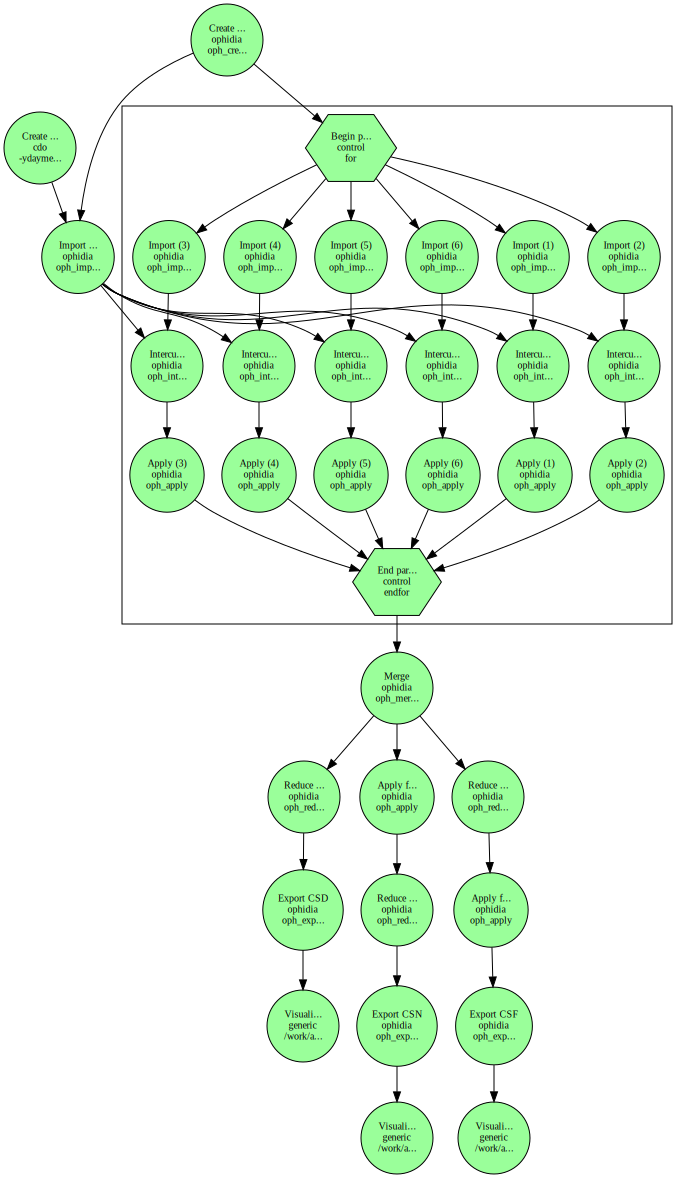

'OPH_STATUS_COMPLETED'

In [3]:
workflow = Workflow(experiment)
workflow.submit()
workflow.monitor(frequency=1, iterative=True, visual_mode=True)

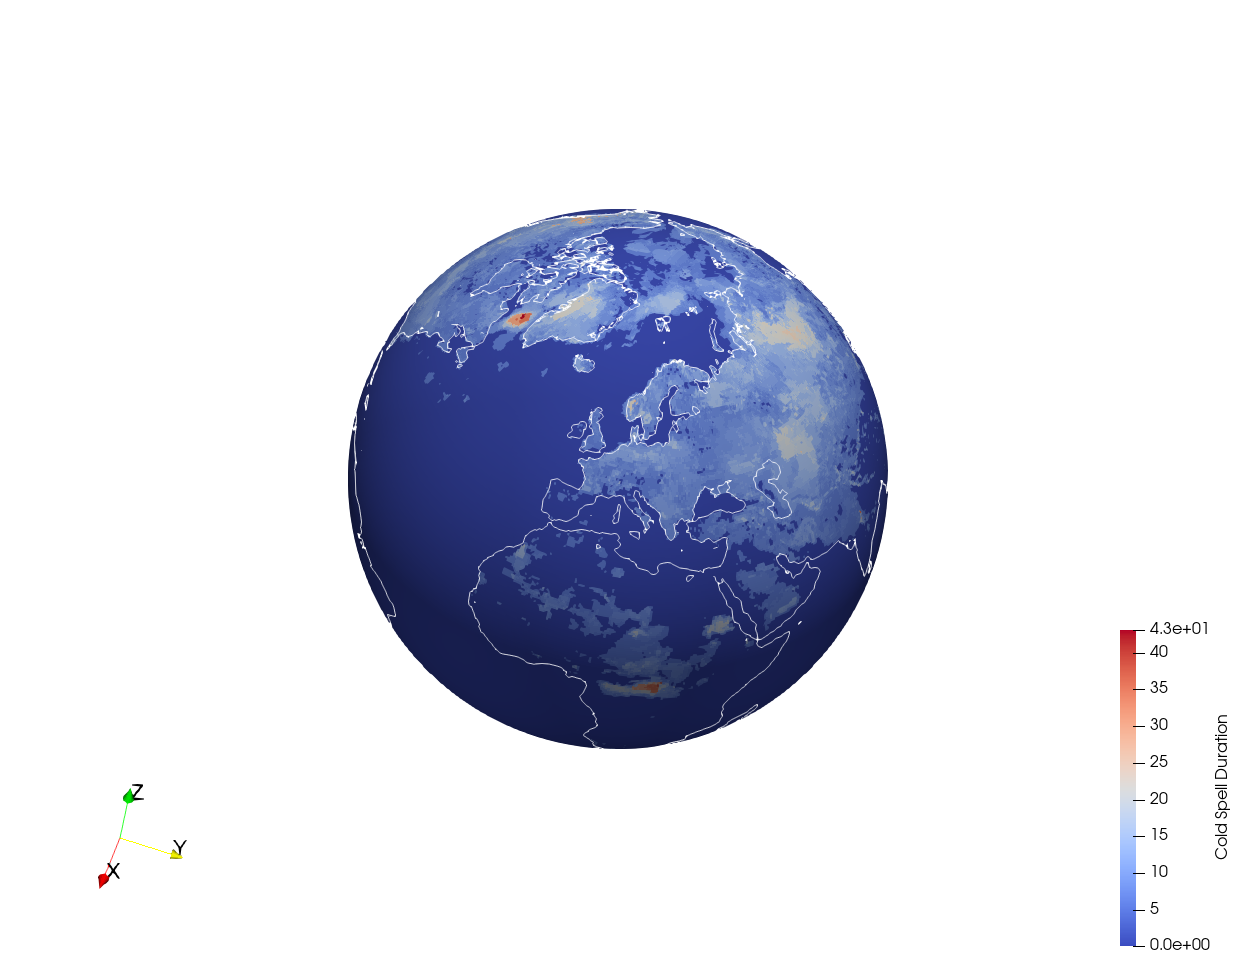

In [4]:
from IPython.display import Image
Image(filename='/path/to/output/CSD.png') 